In [1]:
import os 
import pandas as pd
import numpy as np
import time
import datetime
import zipfile
from tqdm import tqdm
import urllib, json
import folium
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


# import operator
import re,  math  
import glob, sys
import platform

# donwload
import os 
import os.path as path
import requests
from multiprocessing import Pool
from functools import partial

In [2]:
pathName = f'C:/Users/pleasure/학과공모전/'
dirPath = os.listdir(pathName)

In [3]:
url = 'https://raw.github.com/PinkWink/DataScience/master/data/02.%20skorea_municipalities_geo_simple.json'
with urllib.request.urlopen(url) as fp:
    gu_geojson = json.loads(fp.read())

In [4]:
def plot_gu_map(df, value_col, geojson=gu_geojson, legend_name=None, map_title=None):
    if legend_name is None:
        legend_name = value_col

    if map_title is None:
        map_title = f'Seoul Choropleth Map of {value_col}' if legend_name is None \
    else f'Seoul Choropleth Map of {legend_name}'

    # 지도 경계 json 파일에 자치구별 value 정보 추가
    for idx, gu_dict in enumerate(geojson['features']):
        gu_nm = gu_dict['id']
        value = df.loc[df.자치구명==gu_nm, value_col].iloc[0]
        txt = f'{gu_nm}<br>{value:.3f}'
        geojson['features'][idx]['properties']['tooltip1'] = txt


    print(f'\n\n>>> 서울시 자치구별 단계구분도 (기준 : {value_col})')

    m = folium.Map(location=[37.562225, 126.978555], zoom_start=11, tiles='Stamen Toner')
    choropleth = folium.Choropleth(
      geo_data = geojson,
      data = df,
      columns = ['자치구명', value_col],
      fill_color = 'Oranges',
      key_on = 'feature.id',
      fill_opacity=0.9,
      line_opacity=1,
      legend_name=legend_name
    ).add_to(m)
    choropleth.geojson.add_child( folium.features.GeoJsonTooltip(['tooltip1'], labels=False))

    title_html = f'<h3 align="center" style="font-size:20px"><b>{map_title}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    folium.LayerControl().add_to(m)

    return m

In [5]:
# 제공 받은 데이터 로드
#card_origin  = pd.read_csv( pathName + dirPath[4] +"/" + "card_20200717.csv") #데이터 수정 필요
#delivery     = pd.read_csv( pathName + dirPath[4] +"/" + "delivery.csv")
fpopl_origin = pd.read_csv( pathName + dirPath[4] +"/" + "fpopl.csv")
#policy       = pd.read_csv( pathName + dirPath[3] +"/" + "policy_edit.csv") # 제공 policy 기반 
#Time         = pd.read_csv( pathName + dirPath[4] +"/" + "COVID_19/Time.csv")
dong_df  = pd.read_csv( pathName + dirPath[4] +"/" + "adstrd_master.csv") #데이터 수정 필요

In [6]:
dong_df = dong_df[dong_df.brtc_nm == '서울특별시'].drop(columns='brtc_nm')
dong_df['adstrd_code'] = dong_df['adstrd_code'].astype(int)

In [10]:
fpop_df = fpopl_origin[(fpopl_origin.base_ymd < 20200601)]
fpop_df = fpopl_origin.merge(dong_df, how = 'left', on = 'adstrd_code')
fpop_df['weekofyear'] = pd.to_datetime(fpop_df["base_ymd"], format = '%Y%m%d')

In [11]:
fpop_gu = fpop_df.groupby(['signgu_nm', 'weekofyear'])['popltn_cascnt'].sum().divide(7000000).round(2).reset_index()

In [12]:
tmp_list = []
for gu in fpop_gu.signgu_nm.unique():
    tmp_df = fpop_gu[fpop_gu.signgu_nm==gu]
    tmp_pre = tmp_df.loc[fpop_gu.weekofyear.isin(range(2,4)), 'popltn_cascnt'].mean()
    tmp_post = tmp_df.loc[fpop_gu.weekofyear.isin(range(9, 13)), 'popltn_cascnt'].mean()
    tmp_sensitivity = round((tmp_pre - tmp_post)/tmp_pre, 3)
    tmp_list.append(tmp_sensitivity)

fpop_sensitivity_gu = pd.DataFrame({'자치구명':fpop_gu.signgu_nm.unique(), '코로나19_유동인구_민감도':tmp_list})\
                        .sort_values('코로나19_유동인구_민감도', ascending=False).reset_index(drop=True)

# 자치구별 코로나19 유동인구 민감도 막대 그래프
#plot_region_fpop_sensitivity(df=fpop_sensitivity_gu, x_axis='자치구명')

# 자치구별 코로나19 유동인구 민감도 지도 시각화
plot_gu_map(df=fpop_sensitivity_gu, value_col='코로나19_유동인구_민감도', legend_name='COVID-19 Sensitivity')



>>> 서울시 자치구별 단계구분도 (기준 : 코로나19_유동인구_민감도)


In [22]:
tmp_df.loc[fpop_gu.weekofyear.isin(range(2,4)), 'popltn_cascnt']

Series([], Name: popltn_cascnt, dtype: float64)

In [23]:
 tmp_df

,signgu_nm,weekofyear,popltn_cascnt
4032,중랑구,2020-01-01,0.18
4033,중랑구,2020-01-02,0.20
4034,중랑구,2020-01-03,0.21
4035,중랑구,2020-01-04,0.21
4036,중랑구,2020-01-05,0.18
...,...,...,...
4195,중랑구,2020-06-12,0.25
4196,중랑구,2020-06-13,0.24
4197,중랑구,2020-06-14,0.21
4198,중랑구,2020-06-15,0.24


In [20]:
dirPath

['.ipynb_checkpoints',
 '20201029황혼까지 분석.ipynb',
 '20201101 학과공모전.ipynb',
 'DataMiners',
 'KT_data_20200717',
 'pivot_diff_월끼리.ipynb',
 '로밍 19,20 02~08',
 '유동인구 19,20 03~08',
 '통화 20 02~08']

In [7]:
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5158324 entries, 0 to 5158323
Data columns (total 31 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   SERIAL_NUMBER              int64  
 1   PROCESS_DT                 object 
 2   DLVR_RQESTER_ID            object 
 3   DLVR_REQUST_STTUS_VALUE    int64  
 4   DLVR_RCEPT_CMPNY_ID        object 
 5   DLVR_STORE_ID              object 
 6   DLVR_STORE_INDUTY_NM       object 
 7   DLVR_STORE_LEGALDONG_CODE  int64  
 8   DLVR_STORE_SIDO            object 
 9   DLVR_STORE_SIGUNGU         object 
 10  DLVR_STORE_DONG            object 
 11  DLVR_STORE_RI              object 
 12  DLVR_STORE_ADSTRD_CODE     int64  
 13  DLVR_STORE_RDNMADR_CODE    float64
 14  DLVR_DSTN_LEGALDONG_CODE   float64
 15  DLVR_DSTN_SIDO             object 
 16  DLVR_DSTN_SIGUNGU          object 
 17  DLVR_DSTN_DONG             object 
 18  DLVR_DSTN_RI               object 
 19  DLVR_DSTN_ADSTRD_CODE      float64
 20  DL

In [8]:
#delivery --> datetime
#card_origin --> int64
delivery["DLVR_RQESTER_ID"].value_counts()

C000029    290615
C000049    235740
C000028    222671
C000237    209646
C000032    196539
            ...  
C000333         4
C000518         3
C000508         3
C000338         2
C000365         1
Name: DLVR_RQESTER_ID, Length: 162, dtype: int64

In [9]:
delivery["DLVR_RCEPT_CMPNY_ID"].value_counts()

C000043    785226
C000049    232148
C000237    220419
C000130    185533
C000209    139235
            ...  
C000518         2
C000304         2
C000051         1
C000474         1
C000139         1
Name: DLVR_RCEPT_CMPNY_ID, Length: 217, dtype: int64

In [10]:
len(list(set(delivery["DLVR_RQESTER_ID"]) & set(delivery["DLVR_RCEPT_CMPNY_ID"])))

140

In [11]:
cols = ["PROCESS_DT","DLVR_RQESTER_ID","DLVR_REQUST_STTUS_VALUE","DLVR_RCEPT_CMPNY_ID","DLVR_STORE_ID","DLVR_STORE_INDUTY_NM","DLVR_STORE_ADSTRD_CODE", "DLVR_DSTN_ADSTRD_CODE","DLVR_MAN_ID","DLVR_AMOUNT","CALL_RLAY_FEE_AMOUNT","GOODS_AMOUNT","SETLE_KND_VALUE","DLVR_CARALC_TIME","DLVR_COMPT_TIME","DLVR_CANCL_TIME"]
delivery = delivery[cols]
delivery.columns=["처리날짜(datetime)","배달요청업체ID","배달요청상태값","배달접수회사ID","배달상점ID","배달상점업종","상점행정동","목적행정동","배달기사ID","배달비","호출수수료","배달상품금액","결제종류번호","배차시간","완료시간","취소시간"]

In [152]:
delivery.head()

,처리날짜(datetime),배달요청업체ID,배달요청상태값,배달접수회사ID,배달상점ID,배달상점업종,상점행정동,목적행정동,배달기사ID,배달비,호출수수료,배달상품금액,결제종류번호,배차시간,완료시간,취소시간
0,2020-01-01,C000035,1,C000035,S0032342,치킨,4812759000,4.812754e+09,D0005271,4290,300,25000,1,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121061000,1.154551e+09,D0003269,4800,200,49000,2,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,2020-01-01,C000129,1,C000129,S0025740,치킨,1138055100,1.138055e+09,D0001536,3300,300,23000,3,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,2020-01-01,C000029,1,C000043,S0039634,한식,4115051000,4.115051e+09,D0005061,4500,300,20000,2,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,2020-01-01,C000130,1,C000130,S0002237,한식,4128164000,4.128151e+09,D0005215,6500,300,32000,2,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN


In [16]:
delivery_cmp["배달상점업종"].unique()

array(['치킨', '분식', '야식', '족발/보쌈', '회', '피자', '찜탕', '한식', '패스트푸드',
       '카페/디저트', '도시락', '중식', '아시안/양식', '돈까스/일식', '배달전문업체'], dtype=object)

In [153]:
delivery_cmp=delivery[delivery["배달요청상태값"]==1]
delivery_cmp=delivery_cmp.drop("배달요청상태값",axis=1)
#delivery 데이터는 행정동코드가 100곱해져 있는 상태이므로 100으로 나눈다.
delivery_cmp["상점행정동"]=delivery_cmp["상점행정동"]/100
delivery_cmp["상점행정동"]=delivery_cmp["상점행정동"].astype(int)

In [154]:
#서울에 해당하는 데이터만 가져오기
delivery_cmp = delivery_cmp[delivery_cmp["상점행정동"] <= 11740700]
delivery_cmp = delivery_cmp.drop("상점행정동",axis=1)
delivery_cmp = delivery_cmp.drop("목적행정동",axis=1)
delivery_cmp = delivery_cmp.drop("취소시간",axis=1)


In [155]:
delivery_cmp["결제종류번호"] = delivery_cmp.loc[:,"결제종류번호"].astype("object")
delivery_cmp["쓴돈총액"] = delivery_cmp["배달비"] + delivery_cmp["호출수수료"] + delivery_cmp["배달상품금액"]
delivery_cmp = delivery_cmp.drop("배달비",axis = 1)
delivery_cmp = delivery_cmp.drop("호출수수료",axis = 1)
delivery_cmp = delivery_cmp.drop("배달상품금액",axis = 1)
delivery_cmp["건수"]=1
delivery_cmp["건수"] = delivery_cmp["건수"].astype(int)
delivery_cmp["처리날짜(datetime)"] = pd.to_datetime(delivery_cmp["처리날짜(datetime)"], format="%Y-%m-%d")
delivery_cmp.set_index(delivery_cmp['처리날짜(datetime)'], inplace=True)
delivery_cmp = delivery_cmp.drop("처리날짜(datetime)",axis=1)

In [159]:
delivery_cmp.reset_index()
overall = delivery_cmp.groupby("처리날짜(datetime)").sum()
overall = overall.resample('W-sun').agg(sum)
overall = overall.reset_index()
overall["처리날짜(datetime)"]=overall["처리날짜(datetime)"].astype(str)
overall["월"] = overall["처리날짜(datetime)"].str.slice(start=5, stop=7)
overall["주"] = [i for j in (range(1,5), range(1, 5), range(1,6), range(1,5), range(1,6), range(1,4)) for i in j]
overall["월-주차"] = overall["월"].astype(str) + str('월 ') + overall["주"].astype(str) + str('주차')
overall = overall.drop(['월','주'],axis=1)

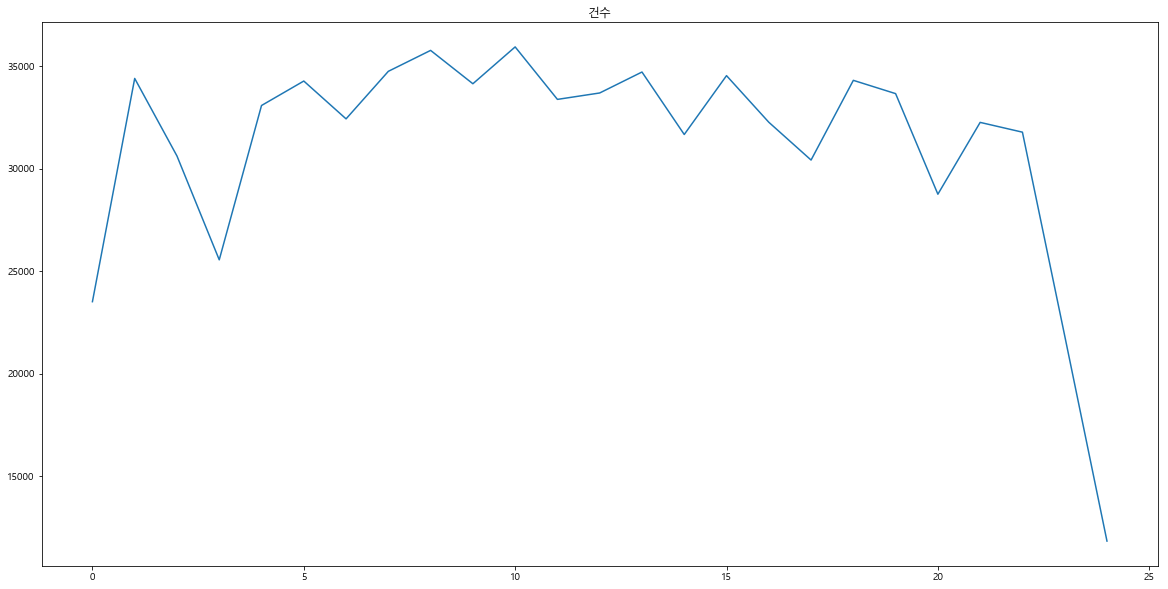

In [162]:
plt.figure(figsize = (20,10))
plt.plot(overall["건수"])
plt.title("건수")
plt.show()

In [92]:
delivery_cmp = delivery_cmp.groupby(["처리날짜(datetime)","배달상점업종"]).sum().reset_index()
delivery_cmp

,처리날짜(datetime),배달상점업종,쓴돈총액,건수
0,2020-01-01,도시락,155980,2
1,2020-01-01,돈까스/일식,3121245,93
2,2020-01-01,배달전문업체,310400,10
3,2020-01-01,분식,16990255,717
4,2020-01-01,아시안/양식,5069215,183
...,...,...,...,...
2454,2020-06-21,카페/디저트,21365145,992
2455,2020-06-21,패스트푸드,15730050,720
2456,2020-06-21,피자,9665570,337
2457,2020-06-21,한식,14345701,532


In [148]:
delivery_pivpr=delivery_cmp.pivot(index='처리날짜(datetime)',columns='배달상점업종',values='쓴돈총액')
delivery_pivfr=delivery_cmp.pivot(index='처리날짜(datetime)',columns='배달상점업종',values='건수')

In [149]:
delivery_pivfr = delivery_pivfr.resample('W-sun').agg(sum)
delivery_pivfr = delivery_pivfr.reset_index()
delivery_pivfr["처리날짜(datetime)"]=delivery_pivfr["처리날짜(datetime)"].astype(str)
delivery_pivfr["월"] = delivery_pivfr["처리날짜(datetime)"].str.slice(start=5, stop=7)
delivery_pivfr["주"] = [i for j in (range(1,5), range(1, 5), range(1,6), range(1,5), range(1,6), range(1,4)) for i in j]
delivery_pivfr["월-주차"] = delivery_pivfr["월"].astype(str) + str('월 ') + delivery_pivfr["주"].astype(str) + str('주차')
delivery_pivfr = delivery_pivfr.drop(['월','주'],axis=1)

In [150]:
delivery_pivfr

배달상점업종,처리날짜(datetime),도시락,돈까스/일식,배달전문업체,분식,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회,월-주차
0,2020-01-05,74.0,543.0,43.0,3614.0,871.0,971.0,1688.0,532.0,272.0,6492.0,2269.0,2200.0,1448.0,1926.0,563.0,01월 1주차
1,2020-01-12,171.0,823.0,101.0,5392.0,1262.0,1467.0,2517.0,707.0,498.0,9483.0,2718.0,3298.0,2084.0,3116.0,759.0,01월 2주차
2,2020-01-19,150.0,680.0,62.0,4846.0,1095.0,1222.0,2045.0,665.0,505.0,8328.0,3183.0,2803.0,1852.0,2572.0,605.0,01월 3주차
3,2020-01-26,117.0,472.0,30.0,3628.0,942.0,1146.0,1726.0,629.0,340.0,7895.0,1466.0,2716.0,1599.0,2173.0,669.0,01월 4주차
4,2020-02-02,121.0,587.0,52.0,5219.0,1455.0,1172.0,2326.0,901.0,538.0,9628.0,2853.0,3267.0,2090.0,2335.0,532.0,02월 1주차
5,2020-02-09,178.0,685.0,53.0,5143.0,1172.0,1390.0,2425.0,865.0,467.0,9295.0,3049.0,4522.0,1998.0,2405.0,622.0,02월 2주차
6,2020-02-16,149.0,708.0,52.0,4953.0,1047.0,1462.0,2207.0,926.0,465.0,8445.0,2842.0,4434.0,1927.0,2293.0,514.0,02월 3주차
7,2020-02-23,198.0,867.0,42.0,4812.0,1086.0,1489.0,2664.0,885.0,598.0,8513.0,3982.0,4467.0,2096.0,2452.0,592.0,02월 4주차
8,2020-03-01,202.0,913.0,37.0,5144.0,1074.0,1348.0,2804.0,1236.0,650.0,9398.0,3492.0,4433.0,2261.0,2209.0,563.0,03월 1주차
9,2020-03-08,178.0,882.0,32.0,4592.0,1034.0,1594.0,2788.0,1031.0,600.0,8771.0,3387.0,4496.0,2039.0,2209.0,504.0,03월 2주차


In [102]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [137]:
list(delivery_temp.columns)[1:16]

['도시락',
 '돈까스/일식',
 '배달전문업체',
 '분식',
 '아시안/양식',
 '야식',
 '족발/보쌈',
 '중식',
 '찜탕',
 '치킨',
 '카페/디저트',
 '패스트푸드',
 '피자',
 '한식',
 '회']

In [142]:
np.array(delivery_temp[['도시락']])[5:]

array([[5300040.],
       [4380945.],
       [5757140.],
       [5929480.],
       [5407620.],
       [4863465.],
       [4447870.],
       [4853885.],
       [5334995.],
       [6061365.],
       [5693210.],
       [4184035.],
       [3564140.],
       [3299105.],
       [4279550.],
       [3260540.],
       [4130170.],
       [3650930.],
       [4103140.],
       [1122510.]])

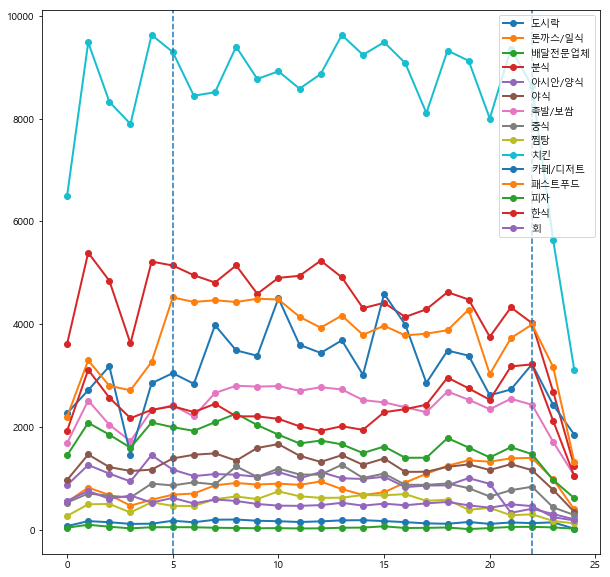

In [151]:
delivery_temp = delivery_pivfr.copy()
fig, ax = plt.subplots(1,1,figsize=(10,10))
for i in list(delivery_temp.columns)[1:16]:
    ax.plot(np.array(delivery_temp[[i]]),marker='o', linewidth=2,label=delivery_temp[[i]].columns[0]) 

ax.axvline(x=5,linestyle ='--')
ax.axvline(x=22,linestyle ='--')
ax.legend()
plt.show()

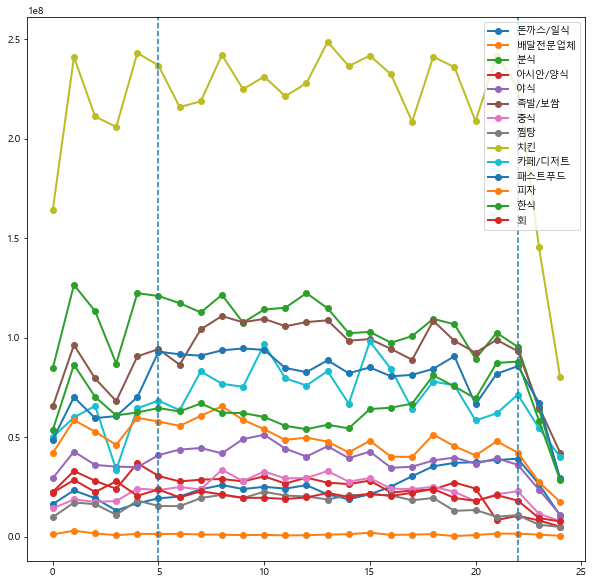

In [146]:
delivery_temp = delivery_pivot.copy()
fig, ax = plt.subplots(1,1,figsize=(10,10))
for i in list(delivery_temp.columns)[2:16]:
    ax.plot(np.array(delivery_temp[[i]]),marker='o', linewidth=2,label=delivery_temp[[i]].columns[0]) 

ax.axvline(x=5,linestyle ='--')
ax.axvline(x=22,linestyle ='--')
ax.legend()
plt.show()

In [42]:
delivery_week=delivery_cmp.drop(["배차시간","완료시간","배달상점업종"],axis=1)
delivery_week["건수"]=1
delivery_week["건수"]=delivery_week["건수"].astype(int)
delivery_week["처리날짜(datetime)"] = pd.to_datetime(delivery_week["처리날짜(datetime)"], format="%Y-%m-%d")
delivery_week.set_index(delivery_week['처리날짜(datetime)'], inplace=True)
delivery_week=delivery_week.drop("처리날짜(datetime)",axis=1)
delivery_week = delivery_week.resample('W-sun').agg(sum)
delivery_week=delivery_week.reset_index(drop=False,inplace=False)
#월-주차로 배달 건수 카운트하기
delivery_week["처리날짜(datetime)"]=delivery_week["처리날짜(datetime)"].astype(str)
delivery_week["월"] = delivery_week["처리날짜(datetime)"].str.slice(start=5, stop=7)
delivery_week["주"] = [i for j in (range(1,5), range(1, 5), range(1,6), range(1,5), range(1,6), range(1,4)) for i in j]
delivery_week["월-주차"] = delivery_week["월"].astype(str) + str('월 ') + delivery_week["주"].astype(str) + str('주차')
delivery_week = delivery_week.drop(['월','주'],axis=1)
cols = ['월-주차', '처리날짜(datetime)', '건수']
delivery_week = delivery_week[cols]

2020-06-21 2020-01-01
